In [79]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from scipy.stats import pointbiserialr

from tqdm import tqdm
from gtfparse import read_gtf

import scanpy
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")


In [81]:
def read_geuvadis(fname_data: Path | str,
                  fname_header: Path | str,
                  fname_gtf: Path | str):
    data_raw = pd.read_csv(fname_data, index_col=0).T
    data_raw = data_raw.astype(np.float32)

    data_header = pd.read_csv(fname_header, index_col=0)

    gtf_rawdata = read_gtf(fname_gtf)
    gtf_data = gtf_rawdata.to_pandas()
    gtf_data = gtf_data.set_index('transcript_id')
    gtf_data['transcript_id'] = gtf_data.index

    gtf_data = gtf_data.drop_duplicates("transcript_id")

    print('Dataset shape: ', data_raw.shape)

    return data_raw, data_header, gtf_data

data_raw, data_header, gtf_data = read_geuvadis(
    fdir_raw / 'Geuvadis.all.csv',
    fdir_raw / 'Geuvadis.SraRunTable.txt',
    fdir_raw / 'all_transcripts_strigtie_merged.gtf'
)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


Dataset shape:  (667, 338725)


In [82]:
data_raw = data_raw[data_raw.columns.intersection(gtf_data.index)]
gtf_data = gtf_data.loc[data_raw.columns.intersection(gtf_data.index)]

data_raw

,ENST00000378604.3,ENST00000307786.8,ENST00000482402.1,ENST00000462293.1,ENST00000378602.3,ENST00000310991.8,ENST00000378598.4,ENST00000470931.2,ENST00000602604.1,ENST00000416272.1,...,ENST00000426199.1,ENST00000517139.1,MSTRG.36845.1,ENST00000619329.1,ENST00000258589.8,ENST00000420810.1,ENST00000431853.1,ENST00000711259.1,ENST00000711266.1,ENST00000711267.1
ERR188021,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
ERR188022,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.074617
ERR188023,0.000000,0.169178,0.114391,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.014311,0.0,0.000000,0.000000,0.000000,0.000000
ERR188024,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.219131,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
ERR188025,0.000000,0.107439,0.017849,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,6.127458,0.000000,4.660298,0.0,4.823868,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.180813,0.0,59.465179,2.708632,3.095435,9.169821
ERR205020,0.134626,0.000000,0.000000,0.0,0.152967,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.769428,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
ERR205021,0.009035,0.000000,0.152969,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
ERR205022,0.031064,0.000000,0.192926,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [83]:
organ = 'HEART'
fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / organ / 'reg' / 'SraRunTable.txt', sep=',', index_col=0)
# data_eval_header


In [84]:
adata = anndata.AnnData(data_raw)
adata.var = gtf_data
adata.obs = data_header

adata

AnnData object with n_obs × n_vars = 667 × 338725
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'

In [85]:
adata_eval = anndata.AnnData(data_eval)
adata_eval.obs = data_eval_header

In [86]:
common_transcripts = adata_eval.var_names.intersection(adata.var_names)

adata_eval = adata_eval[:, common_transcripts]
adata = adata[:, common_transcripts]
adata
# adata[:, adata.var['seqname'] == 'chrY']

View of AnnData object with n_obs × n_vars = 667 × 100178
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'

In [87]:
pseudoautosoms_Y1 = [10001, 2781479]
pseudoautosoms_X1 = [10001, 2781479]
pseudoautosoms_Y2 = [56887903, 57217415]
pseudoautosoms_X2 = [155701383, 156030895]

In [88]:
adata_X = adata[:, adata.var['seqname'] == 'chrX']
adata_Y = adata[:, adata.var['seqname'] == 'chrY']

adata_X = adata_X[:, ((adata_X.var['end'] < pseudoautosoms_X1[0]) 
            | ((adata_X.var['start'] > pseudoautosoms_X1[1]) & ((adata_X.var['end'] < pseudoautosoms_X2[0])))
            | (adata_X.var['start'] > pseudoautosoms_X2[1]))]

adata_Y = adata_Y[:, ((adata_Y.var['end'] < pseudoautosoms_Y1[0]) 
            | ((adata_Y.var['start'] > pseudoautosoms_Y1[1]) & ((adata_Y.var['end'] < pseudoautosoms_Y2[0])))
            | (adata_Y.var['start'] > pseudoautosoms_Y2[1]))]

adata_autosomes = adata[:, ((adata.var['seqname'] != 'chrX') & (adata.var['seqname'] != 'chrY'))]
adata_XY = adata.copy()

adata_auto_X = adata[:, adata_X.var_names.union(adata_autosomes.var_names)]
adata_auto_Y = adata[:, adata_Y.var_names.union(adata_autosomes.var_names)]


adata_Y

View of AnnData object with n_obs × n_vars = 667 × 0
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'

In [89]:
def preprocess(adata):
    adata.layers["counts"] = adata.X.copy()
    scanpy.pp.normalize_total(adata)
    scanpy.pp.log1p(adata)
    adata.obs_names_make_unique()
    return adata


# adata_X = preprocess(adata_X)
# adata_Y = preprocess(adata_Y)
adata_autosomes = preprocess(adata_autosomes)
adata_XY = preprocess(adata_XY)
adata_auto_X = preprocess(adata_auto_X)
adata_auto_Y = preprocess(adata_auto_Y)

/tmp/ipykernel_74673/3818180250.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [90]:
# print(adata_X)
# print(adata_Y)
print(adata_autosomes)
print(adata_XY)
print(adata_auto_X)
print(adata_auto_Y)

AnnData object with n_obs × n_vars = 667 × 97196
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'
    uns: 'log1p'
    layers: 'counts'
AnnDa

In [91]:
adata_XY

AnnData object with n_obs × n_vars = 667 × 100178
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'
    uns: 'log1p'
    layers: 'counts'

In [92]:
for _data in tqdm([adata_autosomes,adata_XY,adata_auto_X,adata_auto_Y]):
        
    scanpy.pp.highly_variable_genes(
        _data,
        flavor="seurat_v3",
        layer='counts',
        n_top_genes=2000,
        # batch_key="Experimental_Factor:_laboratory (exp)",
        subset=True
    )


  0%|          | 0/4 [00:00<?, ?it/s]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
 25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
 50%|█████     | 2/4 [00:03<00:03,  1.70s/it]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
 75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_g

In [93]:
adata_Y

View of AnnData object with n_obs × n_vars = 667 × 0
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'

In [94]:
# scanpy.tl.pca(adata_auto_Y, 100)
# scanpy.pl.pca_variance_ratio(adata_auto_Y, n_pcs=100, log=True)
adata_auto_Y

AnnData object with n_obs × n_vars = 667 × 2000
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id', 'highly_variable', 'highly_variable_rank', 

In [95]:
# adata_auto_Y.obsm['X_pca']

0it [00:00, ?it/s]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:34:12] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
1it [00:08,  8.78s/it]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:34:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
2it [00:17,  8.69s/it]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:34:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
3it [00:26,  8.66s/it]/home/arsenii/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:34:38] WARNING: /workspace/src/context.cc:43: No visi

0.5016345270890725
0.4902367859948379
0.4670851978590857
0.48021944431151586
0.4587878787878788


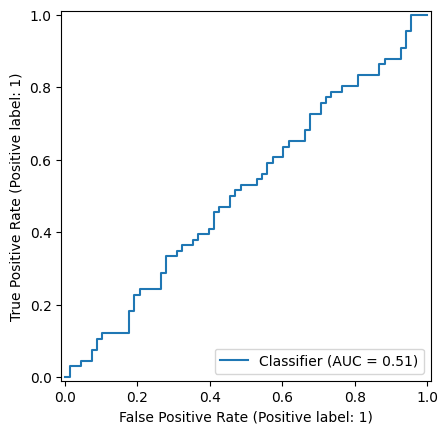

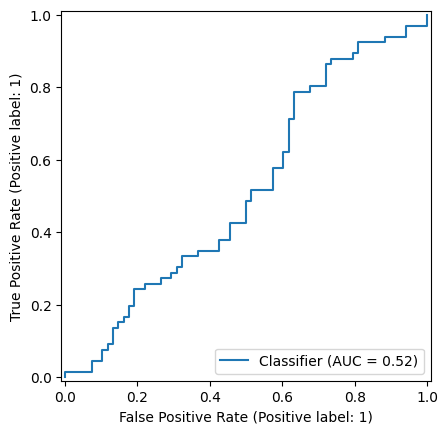

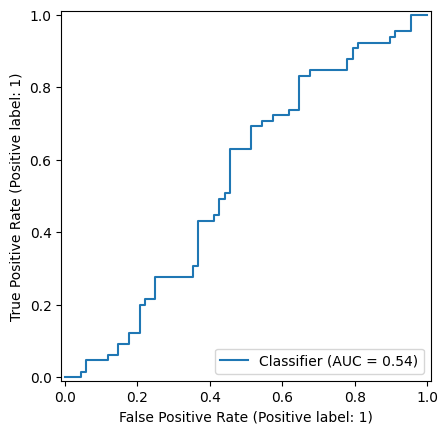

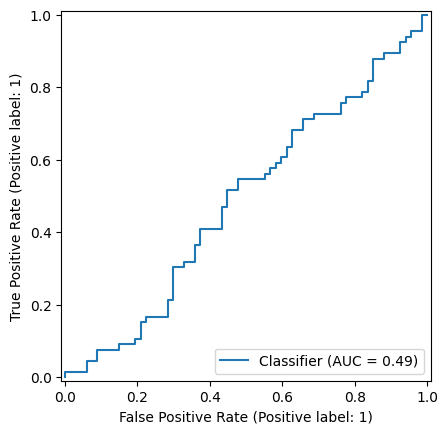

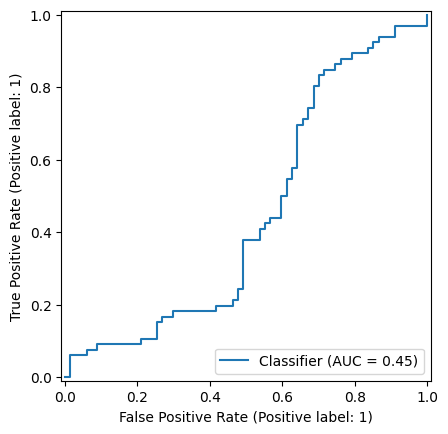

In [98]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
import cupy

cv = StratifiedKFold(n_splits=5)

with open(f'../models/xgboost.json', 'r') as file:
    model_params = json.load(file)

# model_params = {
#     'n_jobs': 6,
#     'objective': 'binary:logistic',
#     'n_estimators': 500,
#     'eta': 0.05,
#     'gamma': 1e-06,
#     'max_depth': 3
# }


X = adata_auto_Y.X
y = adata_auto_Y.obs['Sex']
y = LabelEncoder().fit_transform(y)
        
        
mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    train_scaler = RobustScaler().fit(X_train)
    test_scaler = RobustScaler().fit(X_test)

    X_train = train_scaler.transform(X_train)
    X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    X_val = X_test
    y_val = y_test

    model = xgb.XGBClassifier(**model_params)
    model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], verbose=False)

    pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)

    viz = RocCurveDisplay.from_predictions(
        y_test, pred_prob[:, 1],
        # ax=ax,
    )

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)

    accuracies.append(accuracy_score(y_test, pred))
    f1.append(f1_score(y_test, pred))
    precisions.append(precision_score(y_test, pred))
    recalls.append(recall_score(y_test, pred))
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print(mean_auc)
print(mean_accuracy)
print(mean_f1)
print(mean_precision)
print(mean_recall)
